In this notebook we attempt to predict the angular velocity and air tube motion from G4D.

In [1]:
%reset -f
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

from aux import make_extended_predictor_matrix
from data import DataLoader
import lin_fit
from plot import set_font_size

import CONFIG as C

In [2]:
def plot_overlay(t, y_0, y_1, kwargs_0, kwargs_1, fig_size=(15, 4)):
    
    fig, ax_0 = plt.subplots(1, 1, figsize=fig_size, tight_layout=True)
    ax_1 = ax_0.twinx()
    
    ax_0.plot(t, y_0, **kwargs_0)
    ax_1.plot(t, y_1, **kwargs_1)
    
    return ax_0, ax_1

In [3]:
from db import make_session, d_models

FILT = [d_models.Trial.walking_threshold != None]

session = make_session()
trials = session.query(d_models.Trial).filter(*FILT).all()
session.close()

In [4]:
closed_mask = [trial.expt == 'closed_loop' for trial in trials]
driven_mask = [trial.expt == 'driven_random' for trial in trials]
no_air_mask = [trial.expt == 'no_air' for trial in trials]

c_dict = {'closed_loop': 'k', 'driven_random': 'b', 'no_air': 'r'}

colors = [c_dict[trial.expt] for trial in trials]

In [5]:
for ctr, trial in enumerate(trials):
    print('Loading data for trial {}/{} ({})'.format(ctr+1, len(trials), trial.name))
    trials[ctr].dl = DataLoader(trial, sfx='0', vel_filt=None)

Loading data for trial 1/44 (20170310.Fly2.6)
Loading clean data from file "clean_0.csv"...
Loading data for trial 2/44 (20170310.Fly3.1)
Loading clean data from file "clean_0.csv"...
Loading data for trial 3/44 (20170310.Fly3.2)
Loading clean data from file "clean_0.csv"...
Loading data for trial 4/44 (20170313.Fly1.1)
Loading clean data from file "clean_0.csv"...
Loading data for trial 5/44 (20170313.Fly1.2)
Loading clean data from file "clean_0.csv"...
Loading data for trial 6/44 (20170313.Fly1.3)
Loading clean data from file "clean_0.csv"...
Loading data for trial 7/44 (20170313.Fly1.4)
Loading clean data from file "clean_0.csv"...
Loading data for trial 8/44 (20170313.Fly1.8)
Loading clean data from file "clean_0.csv"...
Loading data for trial 9/44 (20170313.Fly3.1)
Loading clean data from file "clean_0.csv"...
Loading data for trial 10/44 (20170313.Fly3.2)
Loading clean data from file "clean_0.csv"...
Loading data for trial 11/44 (20170313.Fly3.3)
Loading clean data from file "cl

### Predict angular velocities using G4D

In [6]:
WINDOWS = {'g4d': (1, 6)}
rslts = {'v_ang': []}

for trial in trials:
    rslt = lin_fit.regress(trial=trial, targ='v_ang', preds=('g4d',), windows=WINDOWS, valid='all')
    
    # get fraction of time fly is pointed upwind rel to air tube
    frac_uw = np.mean(np.abs(trial.dl.air) < 90)
    rslt.details['frac_uw'] = frac_uw
    
    rslts['v_ang'].append(rslt)

/Users/rkp/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  


### Show R2 and G4D coefs for all trials

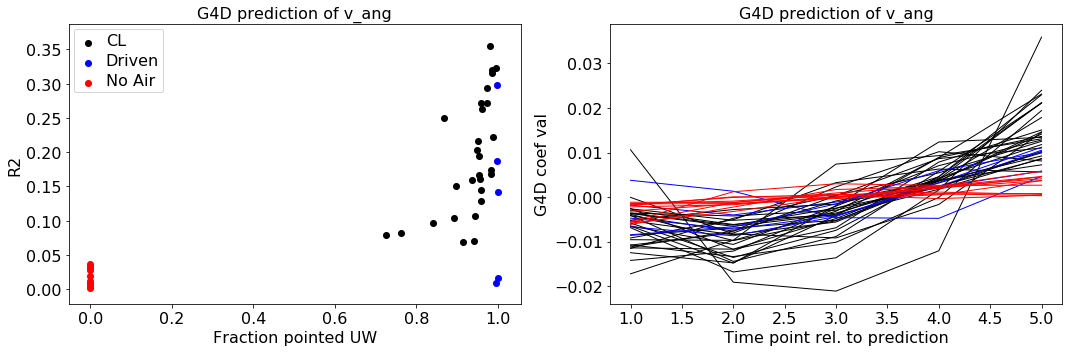

In [7]:
def plot_r2s_vs_frac_uw(targ):

    fig, axs = plt.subplots(1, 2, figsize=(15, 5), tight_layout=True)

    r2s = np.array([rslt.r2 for rslt in rslts[targ]])
    fracs_uw = np.array([rslt.details['frac_uw'] for rslt in rslts[targ]])

    axs[0].scatter(fracs_uw[closed_mask], r2s[closed_mask], s=50, c=c_dict['closed_loop'], lw=0)
    axs[0].scatter(fracs_uw[driven_mask], r2s[driven_mask], s=50, c=c_dict['driven_random'], lw=0)
    axs[0].scatter(fracs_uw[no_air_mask], r2s[no_air_mask], s=50, c=c_dict['no_air'], lw=0)

    axs[0].set_xlabel('Fraction pointed UW')
    axs[0].set_ylabel('R2')
    axs[0].set_title('G4D prediction of {}'.format(targ))
    axs[0].legend(['CL', 'Driven', 'No Air'])

    ts_coef = np.arange(*WINDOWS['g4d'])

    for rslt, trial in zip(rslts[targ], trials):
        if rslt.coefs is not None:
            axs[1].plot(ts_coef, rslt.coefs['g4d'], color=c_dict[trial.expt], lw=1)

    axs[1].set_xlabel('Time point rel. to prediction')
    axs[1].set_ylabel('{} coef val'.format('G4D'))
    axs[1].set_title('G4D prediction of {}'.format(targ))

    for ax in axs:
        set_font_size(ax, 16)
        
plot_r2s_vs_frac_uw('v_ang')

### Predict air tube using G4D

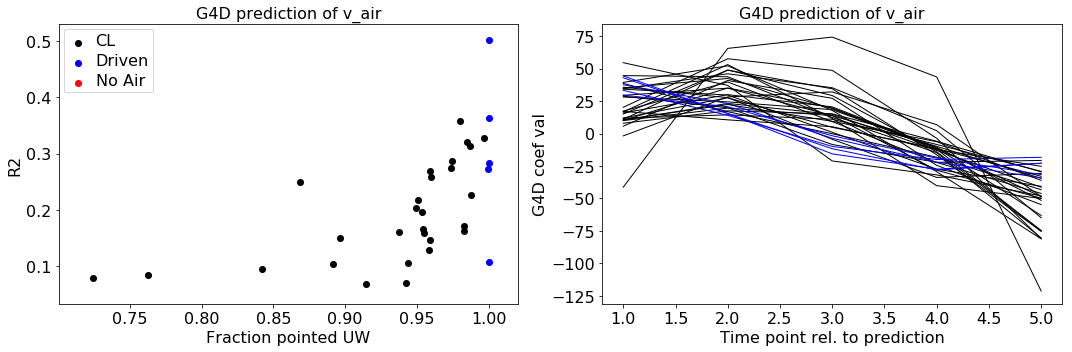

In [8]:
rslts['v_air'] = []

for trial in trials:
    if trial.expt == 'no_air':
        valid = 'none'
    else:
        valid = 'all'
        
    rslt = lin_fit.regress(trial=trial, targ='v_air', preds=('g4d',), windows=WINDOWS, valid=valid)
    
    # get fraction of time fly is pointed upwind rel to air tube
    if not np.all(np.isnan(trial.dl.air)):
        valid_mask = ~np.isnan(trial.dl.air)
        frac_uw = np.mean(np.abs(trial.dl.air[valid_mask]) < 90)
    rslt.details['frac_uw'] = frac_uw
    
    rslts['v_air'].append(rslt)
    
plot_r2s_vs_frac_uw('v_air')

In [9]:
def plot_example_v_ang_prediction(trial_name, fig_size=(15, 5)):
    fig, ax = plt.subplots(1, 1, figsize=fig_size, tight_layout=True)
    
    trial_idx = [trial.name for trial in trials].index(trial_name)
    rslt = rslts['v_ang'][trial_idx]
    
    ts = trial.dl.t
    
    ax.plot(ts, rslt.ys, color='k')
    ax.plot(ts, rslt.ys_pred, color='m')
    
    ax.set_xlabel('t (s)')
    ax.set_ylabel('v_ang')
    ax.set_title('Predicting v_ang from DAN activity')
    ax.legend(['True', 'Predicted'])

    set_font_size(ax, 16)
    
    return ax

def plot_example_air_tube_prediction(trial_name, fig_size=(15, 5)):
    fig, ax = plt.subplots(1, 1, figsize=fig_size, tight_layout=True)
    
    trial_idx = [trial.name for trial in trials].index(trial_name)
    rslt = rslts['v_air'][trial_idx]
    
    ts = trial.dl.t
    
    ax.plot(ts, rslt.ys, color='k')
    ax.plot(ts, rslt.ys_pred, color='m')
    
    ax.set_xlabel('t (s)')
    ax.set_ylabel('v_air (deg/s)')
    ax.set_title('Predicting ddt_air_tube from DAN activity')
    ax.legend(['True', 'Predicted'])

    set_font_size(ax, 16)
    
    return ax

### G4D prediction of angular/air-tube velocity in example Closed Loop trial

(90, 150)

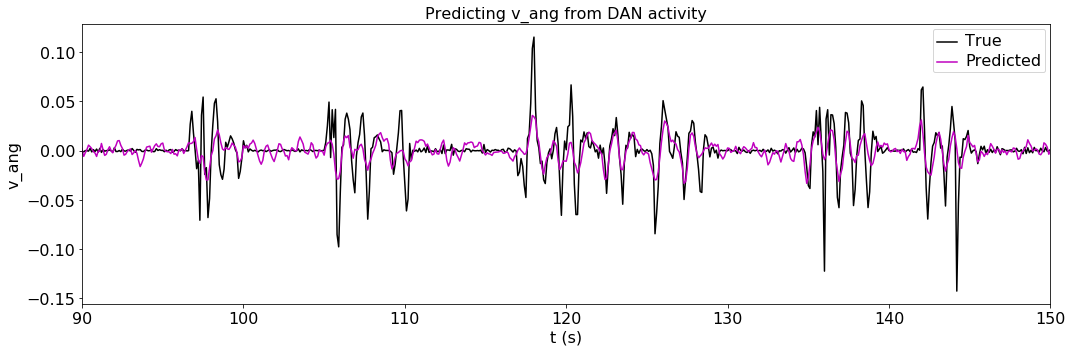

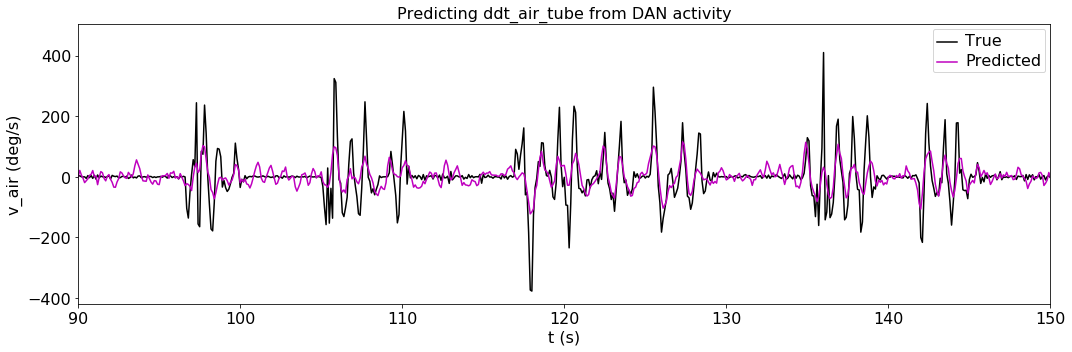

In [10]:
ax = plot_example_v_ang_prediction('20170428.Fly5.1')
ax.set_xlim(90, 150)

ax = plot_example_air_tube_prediction('20170428.Fly5.1')
ax.set_xlim(90, 150)

### G4D prediction of angular velocity vs. air-tube velocity in random air-tube section of driven random trial

(-200, 200)

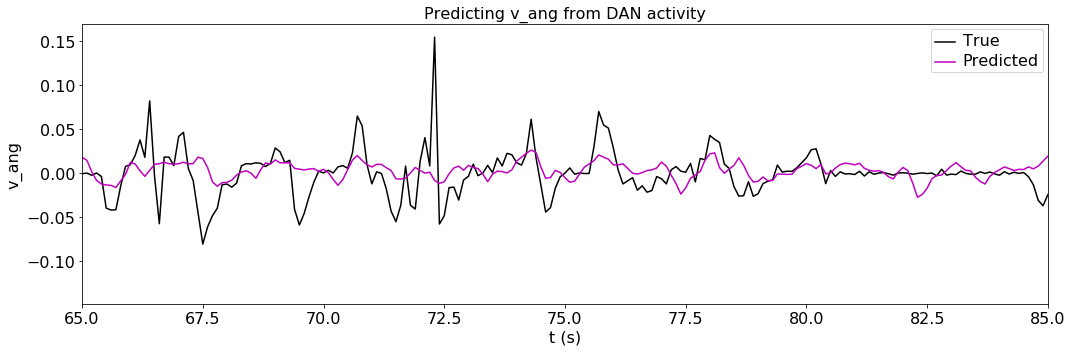

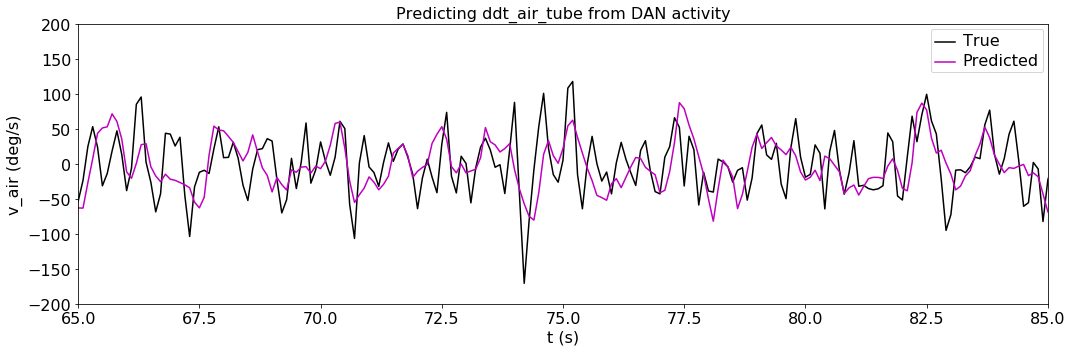

In [11]:
ax = plot_example_v_ang_prediction('20170428.Fly5.5')
ax.set_xlim(65, 85)

ax = plot_example_air_tube_prediction('20170428.Fly5.5')
ax.set_xlim(65, 85)
ax.set_ylim(-200, 200)

### Show results table

In [12]:
df_data = []

for tr_ctr, trial in enumerate(trials):
    df_data.append({
        'Trial': trial.name,
        'Expt': trial.expt,
        'Frac UW': rslts['v_ang'][tr_ctr].details['frac_uw'],
        'R2 (v_ang)': rslts['v_ang'][tr_ctr].r2,
        'R2 (air_tube)': rslts['v_air'][tr_ctr].r2,
    })
    
columns = ['Trial', 'Expt', 'Frac UW', 'R2 (v_ang)', 'R2 (air_tube)']
df = pd.DataFrame(df_data, columns=columns)
df

,Trial,Expt,Frac UW,R2 (v_ang),R2 (air_tube)
0,20170310.Fly2.6,closed_loop,0.914333,0.068537,0.068578
1,20170310.Fly3.1,closed_loop,0.842000,0.096227,0.094923
2,20170310.Fly3.2,closed_loop,0.955000,0.161312,0.159767
3,20170313.Fly1.1,closed_loop,0.959000,0.145297,0.146558
4,20170313.Fly1.2,closed_loop,0.896333,0.150871,0.149522
5,20170313.Fly1.3,closed_loop,0.949000,0.203708,0.202607
6,20170313.Fly1.4,closed_loop,0.959000,0.271305,0.268570
7,20170313.Fly1.8,closed_loop,0.982667,0.174720,0.170593
8,20170313.Fly3.1,closed_loop,0.953667,0.195055,0.196876
9,20170313.Fly3.2,closed_loop,0.985000,0.319754,0.321401


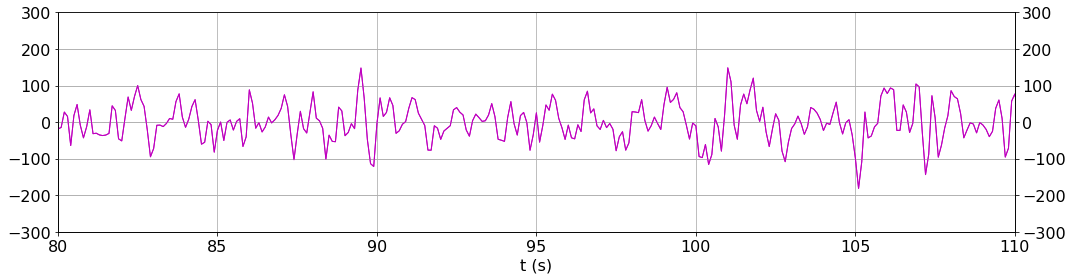

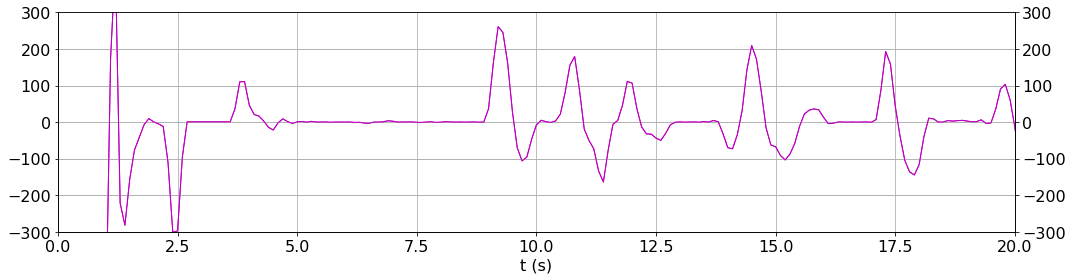

In [13]:
TRIAL_EX = '20170428.Fly5.5'
trial_ex = [tr for tr in trials if tr.name == TRIAL_EX][0]

ax_0, ax_1 = plot_overlay(
    trial_ex.dl.t,
    trial_ex.dl.ddt_air,
    trial_ex.dl.ddt_air,
    kwargs_0={'color': 'm', 'lw': 1},
    kwargs_1={'color': 'm', 'lw': 1})

ax_0.set_xlim(80, 110)
#ax_0.set_xlim(190, 220)
ax_0.set_xlabel('t (s)')

for ax in [ax_0, ax_1]:
    ax.set_ylim(-300, 300)
    ax.grid()
    set_font_size(ax, 16)
    
ax_0, ax_1 = plot_overlay(
    trial_ex.dl.t,
    trial_ex.dl.ddt_air,
    trial_ex.dl.ddt_air,
    kwargs_0={'color': 'm', 'lw': 1},
    kwargs_1={'color': 'm', 'lw': 1})

ax_0.set_xlim(0, 20)
#ax_0.set_xlim(190, 220)
ax_0.set_xlabel('t (s)')

for ax in [ax_0, ax_1]:
    ax.set_ylim(-300, 300)
    ax.grid()
    set_font_size(ax, 16)

Show correlations between R^2s.

In [14]:
df.corr()

,Frac UW,R2 (v_ang),R2 (air_tube)
Frac UW,1.00000,0.702620,0.561390
R2 (v_ang),0.70262,1.000000,0.763092
R2 (air_tube),0.56139,0.763092,1.000000


### Example overlay of true and G4D-predicted air tube in trial with large R2 (20170428.Fly5.1)

(90, 150)

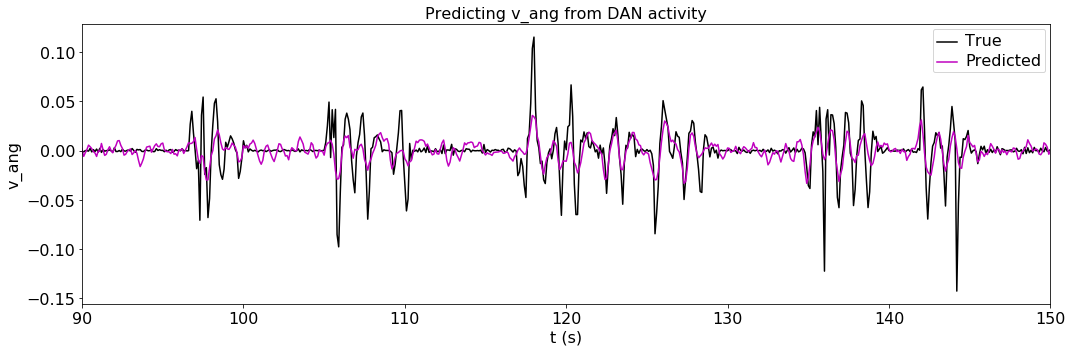

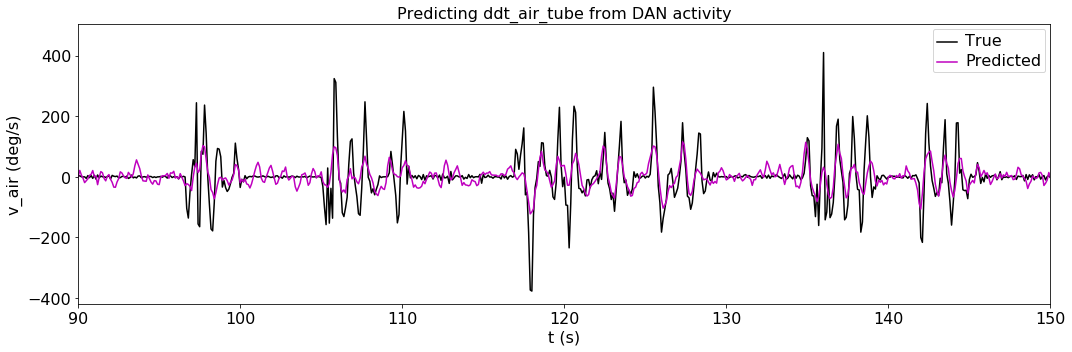

In [15]:
ax = plot_example_v_ang_prediction('20170428.Fly5.1')
ax.set_xlim(90, 150)

ax = plot_example_air_tube_prediction('20170428.Fly5.1')
ax.set_xlim(90, 150)

(-200, 200)

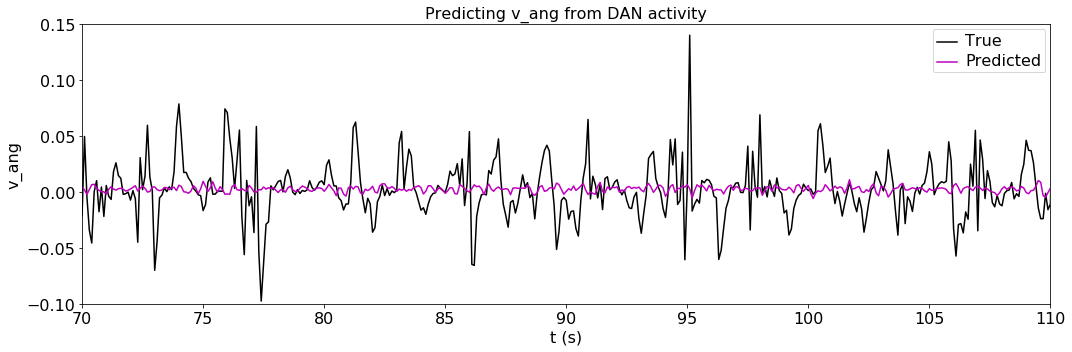

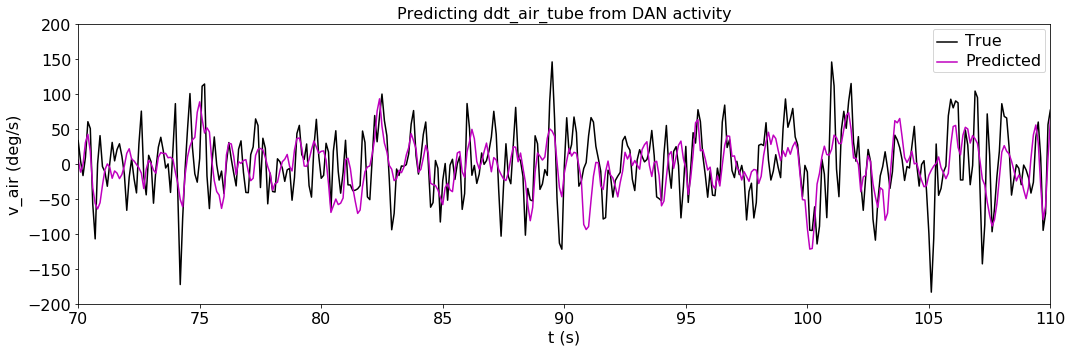

In [17]:
ax = plot_example_v_ang_prediction('20170428.Fly1.5')
ax.set_xlim(70, 110)
ax.set_ylim(-.1, .15)

ax = plot_example_air_tube_prediction('20170428.Fly1.5')
ax.set_xlim(70, 110)
ax.set_ylim(-200, 200)